In [59]:
import os
import pandas as pd
import numpy as np

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [60]:
data_dir = "~/siads696/data"
random_state = 764

In [61]:
df_train = pd.read_parquet(os.path.join(data_dir, "pc256_train_moa.parquet"))
df_test = pd.read_parquet(os.path.join(data_dir, "pc256_test.parquet"))

In [62]:
data_cols = [c for c in df_train if c.startswith("PC")]

In [63]:
X = df_train[data_cols]
y = df_train["Metadata_MoA"]

In [64]:
Xt = df_test[data_cols]
yt = df_test["Metadata_MoA"]

In [65]:
X.shape

(2843, 256)

In [66]:
y.shape

(2843,)

In [67]:
moa_list = df_train[~df_train["Metadata_MoA"].isnull()].loc[:, "Metadata_MoA"].unique().tolist()
moa_dict = {moa: idx for moa, idx in zip(moa_list, range(len(moa_list)))}
n_classes = len(moa_dict.keys())

In [68]:
y = [moa_dict[moa] for moa in y]
yt = [moa_dict[moa] for moa in yt]

In [82]:
xgb_clf = XGBClassifier(objective="multi:softmax", 
                        eval_metric=["merror", "mlogloss"], 
                        learning_rate=0.1,
                        n_estimators=500,
                        max_depth=6,
                        subsample=0.5,
                        early_stopping_rounds=10,
                        num_class=n_classes, 
                        seed=random_state)
xgb_clf.fit(X, y, verbose=0, eval_set=[(X, y), (Xt, yt)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=13, num_parallel_tree=None, ...)

In [85]:
yhat = xgb_clf.predict(Xt)

In [86]:
accuracy_score(yt, yhat)

0.7685018050541517

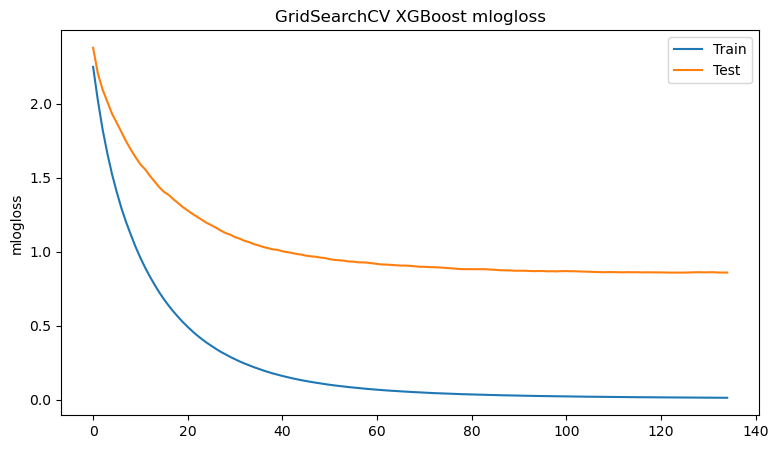

In [83]:
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

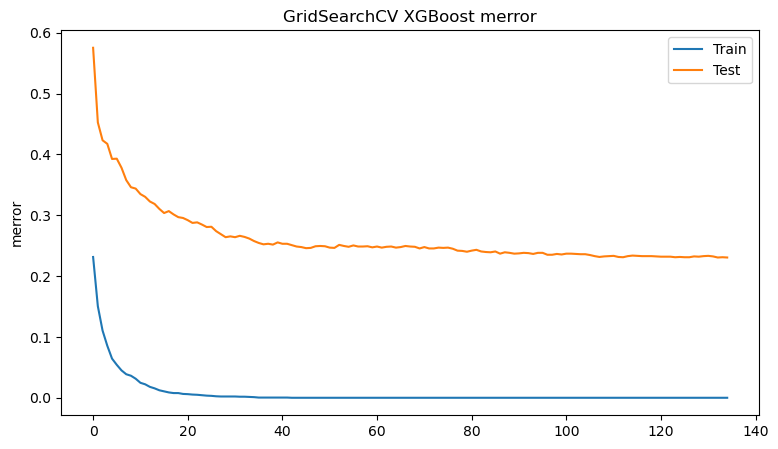

In [84]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()